In [1]:
# copied from `predictions.ipynb`

class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

blood_meta, muscle_meta = load_metadata()

def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value


In [2]:
r2_simulation_size = 10**6

In [15]:
import random
import bisect
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [4]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [5]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [70]:
def present_result(name, tissue, real_allele, simulated_allele, r_squared, p_value, repeats):
    plt.figure()
    plt.scatter(real_allele, simulated_allele)
    plt.xlabel("measured allele length")
    plt.ylabel("predicted allele length")
    plt.title("{} predictions of MAL using {} dataset in {}. r² is {}, corresponding p-value {}".format(repeats, name, tissue, r_squared, p_value))
    print("Repeating the experiment {} times, In {}, {} r² is {}, which corresponds to p-value {}".format(repeats, name, tissue, r_squared, p_value))

In [71]:
import os
os.listdir("simulation_results")

['nakamori_muscle_50_500_2',
 'nakamori_muscle_100_500_5',
 'nakamori_muscle_1',
 'nakamori_muscle_1_500_2',
 'nakamori_muscle_100',
 'batra_blood_10000_500_2',
 'nakamori_muscle_10_500_3',
 'nakamori_muscle_10_500_2',
 'nakamori_muscle_10000_500_2',
 'batra_muscle_10000_500_2',
 'TNNI1_blood_10000_500_2',
 'nakamori_muscle_2_500_2',
 'TNNI1_muscle_10000_500_2',
 'nakamori_muscle_10',
 'nakamori_muscle_10_500_5',
 'nakamori_blood_10000_500_2']

In [72]:
import json

In [73]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [74]:
def present_results_path(path):
    with open(path) as f:
        data = json.load(f)
        predicted_alleles, real_alleles = data["predicted_alleles"], data["real_alleles"]
        r, _ = pearsonr(real_alleles, predicted_alleles)
        r_square = r**2
        filename = path.split("/")[-1]
        name, tissue, simulation_repeat, probes, dimensions = filename.split("_")
        present_result(name, tissue, real_alleles, predicted_alleles, r_square, r2_to_p[tissue](r_square), simulation_repeat)

In [75]:
paths = ["simulation_results/nakamori_muscle_10000_500_2",
         "simulation_results/nakamori_blood_10000_500_2",
         "simulation_results/TNNI1_muscle_10000_500_2",
         "simulation_results/TNNI1_blood_10000_500_2",
         "simulation_results/batra_muscle_10000_500_2",
         "simulation_results/batra_blood_10000_500_2",
        ]

Repeating the experiment 10000 times, In nakamori, muscle r² is 0.18474147991234927, which corresponds to p-value 0.026251000000000024
Repeating the experiment 10000 times, In nakamori, blood r² is 0.019271960846860187, which corresponds to p-value 0.424311
Repeating the experiment 10000 times, In TNNI1, muscle r² is 0.2685814867578523, which corresponds to p-value 0.0063149999999999595
Repeating the experiment 10000 times, In TNNI1, blood r² is 0.03580428540684154, which corresponds to p-value 0.274871
Repeating the experiment 10000 times, In batra, muscle r² is 0.10437985136735552, which corresponds to p-value 0.09988699999999995
Repeating the experiment 10000 times, In batra, blood r² is 0.05181171281813319, which corresponds to p-value 0.18735000000000002


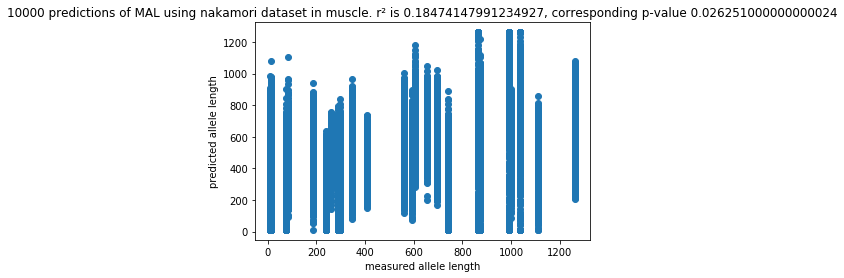

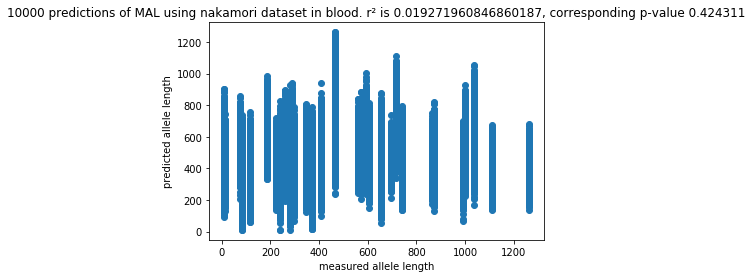

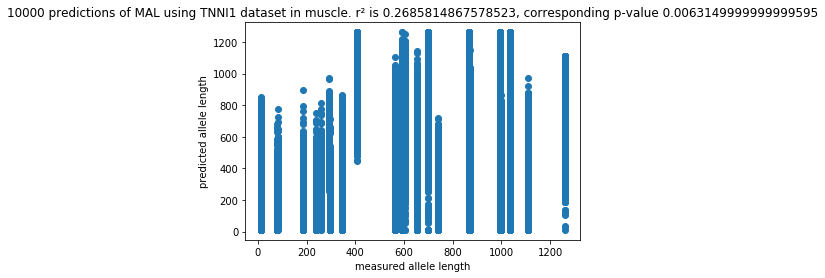

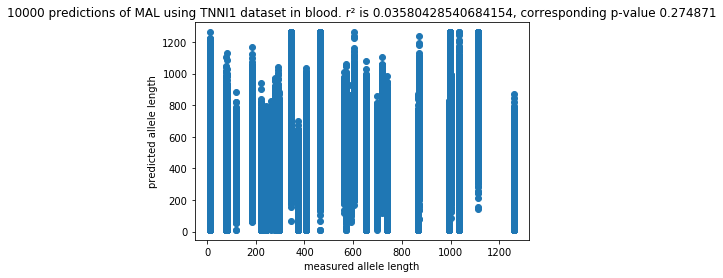

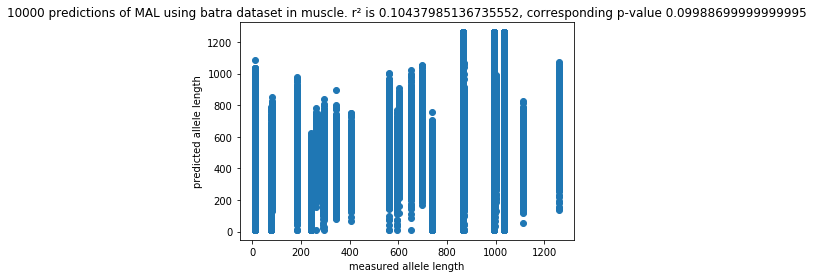

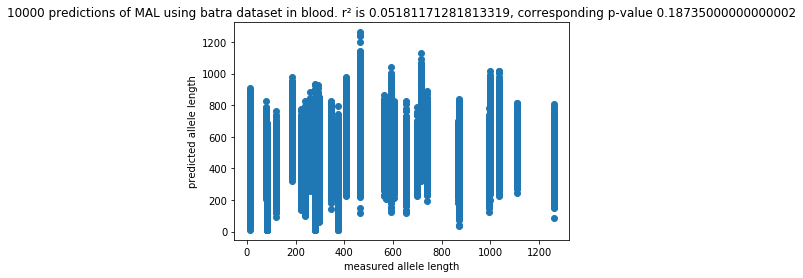

In [76]:
for path in paths:
    present_results_path(path)